Homework 2 — (15 points)
======
### What to hand in
You are to submit the following things for this homework:
1. A Jupyter notebook containing all code and output (figures and audio). I should be able to evaluate the file to reproduce all output. 
1. Any other data that we tell you to save to a file (e.g. audio files). <b>The submission folder must include all the files required for running the entire notebook. 
Points will be deducted if the code crashes because Python cannot find some file.</b> 

### How to hand it in
To submit your lab:
1. Compress all of the files specified into a .zip file. IMPORTANT: ANY OTHER FILES THAT ARE USED IN THIS NOTEBOOK MUST BE INCLUDED IN THE ZIP FILE AS WELL (e.g. external audio files such as piano.wav in this homework, notebooks, etc).
1. Name the file in the following manner, firstname_lastname_hw1.zip. For example, Bryan_Pardo_hw1.zip. 
1. Submit this .zip file via Canvas

## Run this code block 1st, to import some needed packages

In [1]:
# This line is a convenience to import most packages you'll need. You may need to import others (eg random and cmath)
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa, cmath,math
from IPython.display import Audio
 
# This line makes sure your plots happen IN the webpage you're building, instead of in separate windows.
%matplotlib inline

# Feel free to add some other imports here, if that is helpful

def make_sinewave(f, t, sr):
    """    
    Parameters
    ----------
    f:  float
        Frequency of sine wave
    t:  float
        Duration in seconds
    sr: int
        Sample rate
    
    Returns
    -------
    np.ndarray 
        Array of floats containing the signal
    """
    time = np.arange(0,t*sr)/sr
    sine_wave = np.sin(2*np.pi*f*time)
    return sine_wave

def plot_audio(x, sr, figsize=(16,4)):
    """
    A simple audio plotting function
    
    Parameters
    ----------
    x: np.ndarray
        Audio signal to plot
    sr: int
        Sample rate
    figsize: tuple
        A duple representing the figure size (xdim,ydim)
    """
    length = float(x.shape[0]) / sr
    t = np.linspace(0,length,x.shape[0])
    plt.figure(figsize=figsize)
    plt.plot(t, x)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.show()

/Users/olivergoodman/miniconda2/envs/eecs352/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Implementing a spectrogram 

#### 1. (2 points) Make a short term Fourier transform (STFT) function.  

In [2]:
from scipy.fftpack import fft
from scipy.signal import hann

def stft(signal, window_size, hop_size, window_type = 'hann'):
    """
    Computes the short term fourier transform of a 1-D numpy array, where the array 
    is windowed into a set of subarrays, each of length window_size. The distance between
    window centers (in samples) is given by hop_size. The type of window applied is
    determined by window_type. This returns a 2-D numpy array where the ith column
    is the FFT of the ith window. Each column contains an array of complex values.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    window_type: a string specifying one of two "hann" or "rectangular"
    
    Returns
    -------
    a 2D numpy array of complex numbers where the array column is the FFT of the ith window,
    and the jth element in the ith column is the jth frequency of analysis.
    """
    window = np.ndarray(shape=(0, ))
    if window_type == 'rectangular':
        window = sp.signal.boxcar(window_size)
    elif window_type == 'hann':
        window = sp.signal.hann(window_size)
        
    t = np.ndarray(shape=(window_size, math.ceil(signal.size/float(hop_size))), dtype=complex)
    i = 0
    j = 0
    while (i < len(signal)):
        w = signal[i:i+window_size]
        if (w.size < window_size):
            w_size = w.size
            w = np.insert(w, 0, np.zeros(.5*(window_size-w_size)))
            w = np.append(w, np.zeros(math.ceil(.5*(window_size-w_size))))
        f = fft(w*window)
        t[:, j] = f
        i += hop_size
        j += 1
    
    return t
        

#### 2. (2 points) 
1. **Make a signal $S$ of length 300 that has 1 for every one of its 300 samples.** 
1. **Make a signal $W_1$ by windowing signal $S$ with a Hann window of length 200, starting at index 0.**  
1. **Make signal $W_2$ by windowing signal $S$ with a Hann window of length 200, starting at index 100.** 
1. **Now....make a reconstruction of $S$ from $W_1$ and $W_2$ by overlapping the two windowed signals 50% (the same way you took them from $S$ and adding them together....where $W_1[100]$ would aling with $W_2[0]$. This is called "overlap and add." **

**How much does the reconstructed signal look like the original? What happens if these windows are not overlapped 50%, but by some other amount?**   

The reconstructed signal with the hann windowing shows how the different windows (w1 and w2) have amplitudes that add up to 1. Compared to the original signal, which is just a constant amplitude.  If the windows were overlapped by greater than 50%, the reconstruction would have amplitdues that would exceed 1. Conversely, if the windows overlapped by less than 50%, the reconstruction would begin to resemble a signal of multiple hann waves tagged on together. Since the overlap portion would be smaller, there would be less area on the signal where the amplitude is 1. 

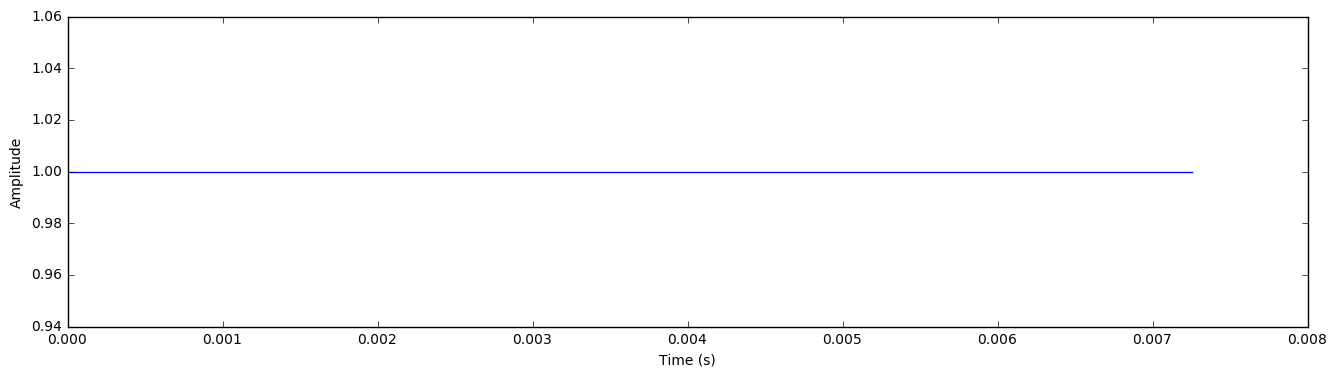

In [3]:
sr = 44100

ones = np.ones(shape=320)

w1 = ones[0:200] * sp.signal.hann(200)
w2 = ones[100:300] * sp.signal.hann(200)
x = np.append(w1[0:100], w1[100:200] + w2[0:100])
ones_new = np.append(x, w2[100:200])

plot_audio(ones, sr)
plot_audio(ones_new, sr)

#### 3. (2 points) Make an inverse STFT function to rebuild the original audio signal, using overlap & add resynthesis. You don't need to use a window function here.

In [4]:
from scipy.fftpack import ifft

def istft(X, hop_size):
    """
    Takes a 2-D numpy array representing an STFT of some signal, where stft[i] 
    is the FFT of the ith window as input and stft[i,k] is the kth frequency of analysis.
    Performs an inverse FFT on each window and then does overlap & add resynthesis to rebuild 
    the original signal the STFT was built from.
    
    Input Parameters
    ----------------
    X: a 2-D numpy array of complex numbers representing an STFT, where the ith 
    column is the FFT of the ith window, and the jth row is the jth frequency of analysis.
        
    hop_size: an integer specifying the number of samples between the start of adjacent windows.
        
    Returns
    -------
    a 1-d numpy array of (possibly complex) values representing the original signal used to make X
    """
    window_len = X.shape[0]
    num_windows = X.shape[1]
    sig_len = (hop_size*num_windows) + window_size
    ret = np.zeros(shape=sig_len, dtype=complex)
    n = 0
    start = 0
    while n < num_windows:
        s = ret[start : start + window_len]
        overlap = ifft(X[:, n])
        if (s.size < overlap.size):
            overlap = overlap[s.size:]
        ret[start: start + window_len] = s + overlap
        start += hop_size
        n += 1
    return ret

#### 4. (2 points) Display a magnitude spectrogram of an audio signal. Magnitude must be in dB. Correct frequencies must be displayed. Display only frequencies up to the Nyquist rate.  Time must be displayed in seconds. You cannot use any functions in librosa to do this.  

<i>HINT: You may need to rotate your axes to get the visual results that you are looking for. Experiment with np.fliplr or np.rot90.</i>

/Users/olivergoodman/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/olivergoodman/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/olivergoodman/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(array([[ 52.32053749,  65.19175753,  40.81928459, ...,  74.67382317,
          81.06709128,  78.91671213],
        [ 59.74340465,  60.70324856,  47.61031261, ...,  73.89450658,
          79.41462267,  77.78876457],
        [ 55.04300065,  47.40083689,  46.70871048, ...,  65.32197415,
          69.77582842,  74.24276029],
        ..., 
        [-74.95996206, -73.21335574, -65.77059837, ...,  41.69089983,
          35.73481345,  51.49696179],
        [-76.06894015, -73.364908  , -68.10972344, ...,  30.59982953,
          36.51921642,  47.2370798 ],
        [-78.51270348, -72.28328869, -71.03760189, ...,  30.34026663,
          30.90017737,  45.55096076]]),
 array([  0.00000000e+00,   6.40058055e-02,   1.28011611e-01, ...,
          4.84971988e+02,   4.85035994e+02,   4.85100000e+02]),
 array([   0.    ,    7.8125,   15.625 ,   23.4375,   31.25  ,   39.0625,
          46.875 ,   54.6875,   62.5   ,   70.3125,   78.125 ,   85.9375,
          93.75  ,  101.5625,  109.375 ,  117.1875,  125.

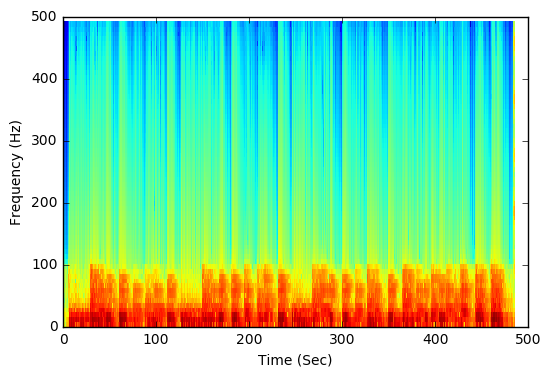

In [12]:
def spectrogram(signal, window_size, hop_size, sample_rate, window_type = 'hann', display = 1 ):
    """
    Computes the short term fourier transform of a 1-D numpy array, where the array 
    is windowed into a set of subarrays, each of length window_size. The distance between
    window centers (in samples) is given by hop_size. The type of window applied is
    determined by window_type. This creates a 2-D numpy array where the ith column
    is the FFT of the ith window. Each column contains an array of complex values.
    It then creates a magnitude spectrogram of the signal and plots it on the screen.
    Here, the vertical dimension is frequency (in Hz), the horizontal dimension is time
    (in seconds), brightness corresponds to amplitude (in dB). Only frequencies up to
    the Nyquist rate are displayed.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    sample_rate: an integer giving the sample rate of the input signal, in Hz
    window_type: a string specifying one of two "hann" or "rectangular"
    display: an integer. If set to 1, it plots the spectrogram. Else it does not.
    
    Returns
    -------
    an output tuple with 3 items
    
    sgram:  a 2-D numpy array of real-valued numbers that contains the magnitude spectrogram
           sgram[t,f] is the magnitude at time t and frequency f. This only contains values
           up to the nyquist frequency
    times: a 1-D numpy array of non-negative real-values that gives the times,  
           times[t] gives the start time of the tth window in seconds
    freqs: a 1-D numpy array  of non-negative real values. freqs[f] gives the fth
           frequency of analysis in Hz, up to the nyquist frequency
           
    Calling Example
    ---------------
    sgram,times,freqs = spectrogram(signal, window_size, hop_size, sample_rate )

    """ 
    fourier = stft(signal, window_size, hop_size, window_type)
    sgram = fourier[:window_size/2]
    len_secs = signal.shape[0]/float(sample_rate)
    times = np.linspace(0, len_secs, fourier.shape[1])
    freqs = (np.fft.fftfreq(window_size) * sample_rate)[:window_size/2]
    
    mags = np.absolute(sgram)
    sgram = 20*np.log10(mags/10e-6)
    
    if display == 1:
        plt.pcolormesh(times, freqs, sgram)
        plt.xlabel("Time (Sec)")
        plt.ylabel("Frequency (Hz)")
        
    return (sgram, times, freqs)

spectrogram(piano, 128, 64, 1000, window_type='hann', display=1)

## Manipulating audio

#### 5. (1 point) Increase the speed of playback for the file piano.wav by 25%...but don't change the pitch. (don't use librosa)

In [6]:
piano, sr = librosa.load('piano.wav', sr=sr, duration=30)
window_size = 10000
hop_size = 5000
sr = 44100
s = stft(piano, window_size, 7500)
i = istft(s, hop_size)
Audio(i, rate=sr)

/Users/olivergoodman/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/olivergoodman/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/olivergoodman/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/olivergoodman/miniconda2/envs/eecs352/lib/python2.7/site-packages/IPython/lib/display.py:123: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


#### 6. (1 point) Now increase the pitch of file piano.wav by  two musical whole steps without changing the duration of the audio. (again.... don't use librosa)

In [7]:
val = 2**(1/6.)
s2 = stft(piano, window_size, hop_size)
i2 = istft(s2, hop_size*val)
Audio(i2, rate=int(sr*val))

/Users/olivergoodman/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/olivergoodman/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/olivergoodman/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/olivergoodman/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/olivergoodman/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer nu

## Log Frequency 

In this part of the homework, you're going to remap the energy in the spectrum from something that is lienearly spaced to something that is not. You will do this by defining a set of filters.

Let's look at a concrete example of making a single filter. Say you have a sample rate of 8000 Hz and you have a window of 800 samples. You take the spectrum of this window, giving you 800 frequencies of analyis, spaced 10 Hz apart. Now you toss out everything above the Nyquist frequency. The reason we do this is that we'll be building this filter for visualization purposes only. The Nyquist frequency in this case would be 4000, since it is 1/2 the sample rate. Frequencies above the Nyquist frequency are a mirror image of the ones below and don't help the visualization. 

This gives you 401 frequencies we need to consider when defining the filter response of a single filter. You'd declare a vector of 401 and fill in each of those 401 bins with the strength of response the filter has to energy at the frequency corresponding with that bin. That response value should range between 0 and 1.

Let's make a single, asymmetric triangular filter that has a center frequency of 105 Hz and a width of 50 Hz on the low side (i.e. it is completely insensitive to sounds  lower than 55) and 100 Hz on the high side (it is insensitive to sound above 205 Hz). We have to figure out the slope of 2 lines. One that starts at frequency f=105, response r=1 and ends at f=55, r=0. Then we do the same for f=105, r=1 and ends at f=205,r=0.  Once we have those two formulae, we can calculate the value that goes into each of the 401 bins. Since you know the frequencies of analysis are 10 Hz apart, it should be straightforward to get the frequency of each bin. Note...it should already be obvious to you that all bins corresponding to frequencies below 55Hz or above 205Hz should have a response of 0. I trust you to figure out how to use the slope of a line to fill in the values for the remaining bins.

To make a filter bank with multiple filters at different center frequencies, we have an array with multiple vectors in it, one vector for each filter.  Now that we have our filter bank, we can remap energy from the linearly spaced domain of the spectrum calculated with an FFT to any frequency spacing we like.  We simply have 1 filter at each center frequency we care about and do the remapping.

Let's say we have 10 filters, each with a different center frequency, spaced in some non linear way.  We create a 10-element vector. The value that goes in the ith vector element is the energy of the whole spectrum, where the magnitude spectrum is first multiplied (element-wise) by the ith filter. So, for our example of a 401 element spectrum, we'd multiply the magnitude spectrum at each frequency by the response of the filter at that frequency and then sum the result of these 401 multiplications. Do this once for each filter. That's it. We now have a ten-element vector that represents the energy of the spectrum. This can then be plotted where the x axis is the center frequency of the filter and the y axis is the output of the filter applied to the spectrum of the signal. 

Now that you've got the idea, it's time to implement this.


#### 7. ( 2 points) Write a function that emulates triangular filters in the frequency domain. This function will be used to map from the linearly spaced frequencies of the STFT to another specified set of frequencies, with arbitrary spacing.  Note that we'll only be working with frequencies up to the Nyquist rate. 

In [8]:
def make_triangular_filters(cfreqs, freqs, nyquist ):
    """
    Computes a set of "filters" to apply to an STFT to change its frequency scaling.
    This takes an array of center frequencies (cfreqs) and a set of frequencies of 
    analysis from your Fourier transform (freqs) as input, both coded in Hz.  It will 
    return a 2-D numpy array filters[c][f], where c is the index number of a center 
    frequency in cfreqs and f is the index to a frequency in freqs and the value in 
    filters[c][f] gives the filter magnitude (a number between 0 and 1 that represents 
    how sensitive this filter is to that frequency). 
    
    Filters are triangular, with a linear decrease in sensitivity from the center 
    frequency (sensitivity = 1) down to a sensitivity of 0 by the center frequency 
    of each adjacent freqency. The lowest center frequency will decrease to 0 by 
    0 Hz on the low end. The highest center frequency will decrease to 0 by the 
    Nyquist frequency on the high end.
    
    Note: you do not have to normalize the filters by energy in this exercise 
    (the maximum magnitude for all filters is equal to 1).
    
    Input Parameters
    ----------------
    cfreqs: a 1-D python array of center frequencies measured in Hz
    freqs:   a 1-D python array of frequencies for whom we need to calculate the sensitivity
             of each filter (also measured in Hz)
    nyquist: the frequency of the nyquist rate. By default, the filter with the highest 
            center frequency will have its response reach 0 at the nyquist frequency. 
    
    Returns
    -------
    filters: a 2-D numpy array, where c is the index number of a center frequency in 
            cfreqs and f is the index to a frequency in freqs and the value in filters[c][f] 
            is a number between 0 and 1 that represents how sensitive this filter is to 
            that frequency.
            
    """
    filters = np.zeros(shape=(cfreqs.size, freqs.size))
    start = 0.0
    for i, center in enumerate(cfreqs):
        if i+1 > cfreqs.size-1:
            next_center = nyquist
        else:
            next_center = cfreqs[i+1]
        
        slope_up = 1.0/(center-start)
        slope_down = 1.0/(next_center-center)
        
        for j, freq in enumerate(freqs):
            if freq > start and freq <= center:
                r = (freq-start)*slope_up
                filters[i][j] = r
            elif freq > center and freq < next_center:
                r = 1 - ((freq-center)*slope_down)
                filters[i][j] = r
        
        start = center
    
    return filters

#### 8. (1 point) You have been given a set of input frequencies spaced 1 Hz apart and ranging from the bottom piano note to the top note...and a second set of a center frequencies that are spaced with 1 per key on the piano. Use your code from problem 7 to create a filterbank, mapping the energy from the first set of frequencies to the second set of frequencies. Then display the filterbank as a 2-D image where the vertical dimension is freq in Hz, the horizontal dimension is the index of a filter (i.e. the piano key number) and the color gives the strength of the filter response. Label your dimensions. Also, give a list of the piano key frequencies below the plot. 

/Users/olivergoodman/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in double_scalars


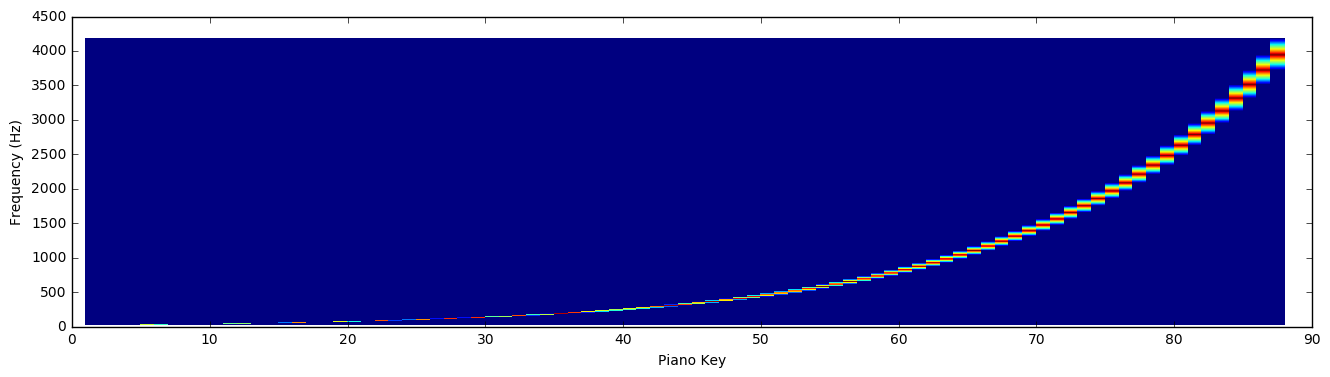

In [9]:
# A440 is 39 keys from the top of the piano and 44 keys from the bottom
top_piano_note =  440*2**(39.0/12)
bottom_piano_note = 440*2**(-48.0/12)

# our frequencies will be spaced 1 Hz appart in this domain
freqs = np.linspace(bottom_piano_note,top_piano_note,(top_piano_note-bottom_piano_note + 1))

# our center frequencies will be spaced with one per piano note
cfreqs = bottom_piano_note * np.logspace(0, 87.0/12, 88, base=2)

#---------------------
# your code goes below
#---------------------

filters = make_triangular_filters(cfreqs, freqs, top_piano_note)

piano_keys = np.linspace(1, 88, num=88)
plt.figure(figsize=(16,4))
plt.xlabel("Piano Key")
plt.ylabel("Frequency (Hz)")
plt.pcolormesh(piano_keys, freqs, np.rot90(filters[::-1], 3))

#### 9. (2 point)  Use the mapping from frequency $f$ to mel $m$ defined in (1) to make a mel-frequency filter bank with 40 filters, evenly spaced in mels, that covers the same range as the piano-note spaced filterbank.  Display a plot of it. Give a list of the mel frequencies (in Hz). Do you think this number of filters and spacing appropriately captures the salient aspects of music? Why or why not?

$m = 2595log_{10}(1+\frac{f}{700})$

(1) Douglas O'Shaughnessy (1987). Speech communication: human and machine. Addison-Wesley. p. 150. ISBN 978-0-201-16520-3.

Yes, the mel-frequency filter bank capture the linearity of how notes are spaced on the piano. As frequencies increase on the piano, we perceive them increasing in pitch linearly, which is what the mel filter bank visually portrays as a linear figure (even though the actual frequencies increase logarithmically in Hz)

[   43.42721509    98.46259183   153.49796857   208.53334531   263.56872205
   318.60409879   373.63947553   428.67485227   483.71022901   538.74560575
   593.78098249   648.81635923   703.85173597   758.88711271   813.92248945
   868.95786619   923.99324293   979.02861967  1034.06399641  1089.09937315
  1144.13474989  1199.17012663  1254.20550337  1309.24088011  1364.27625686
  1419.3116336   1474.34701034  1529.38238708  1584.41776382  1639.45314056
  1694.4885173   1749.52389404  1804.55927078  1859.59464752  1914.63002426
  1969.665401    2024.70077774  2079.73615448  2134.77153122  2189.80690796]
[[ 0.63324346  0.65627332  0.67930317 ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.      

/Users/olivergoodman/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in double_scalars


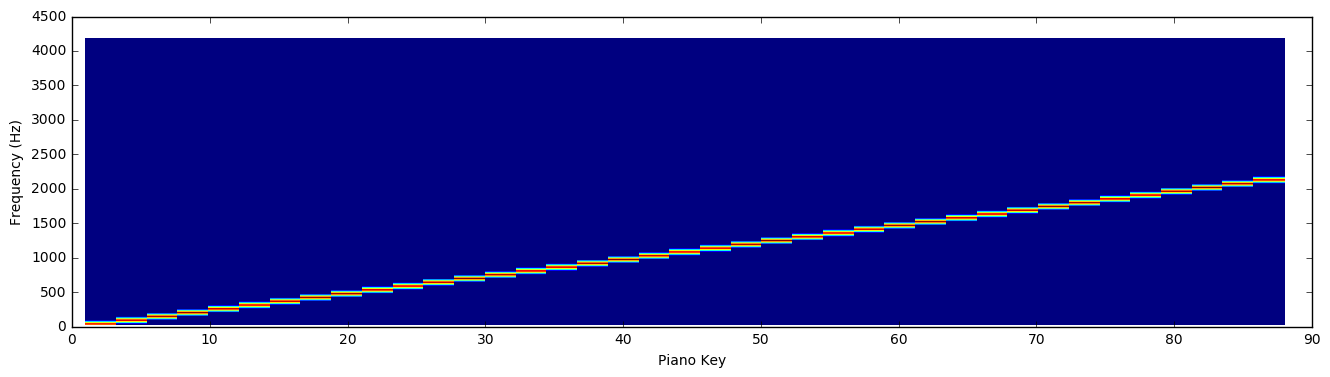

In [10]:
#---------------------
# your code goes below
#---------------------
mel_top = 2595 * math.log10(1+(top_piano_note/700.))
mel_bottom = 2595 * math.log10(1+(bottom_piano_note/700.))
mel_space = np.linspace(mel_bottom, mel_top, 40)

print mel_space

mel_filters = make_triangular_filters(mel_space, freqs, mel_top)
print mel_filters

piano_keys = np.linspace(1, 88, num=40)
plt.figure(figsize=(16,4))
plt.xlabel("Piano Key")
plt.ylabel("Frequency (Hz)")
plt.pcolormesh(piano_keys, freqs, np.rot90(mel_filters[::-1], 3))
